# WDNN Tutorial 02 - California Housing Prices

Using the `keras` functional API to build wide and deep neural networks for predicting housing prices in California.

This is an example from Chapter 10 of Aurelien Geron's textbook, and can be found [here](https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb).

# Setup

In [0]:
# Python 3.5 or above 
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn version 0.20 or above
import sklearn
assert sklearn.__version__ >= "0.20"

# Tensorflow 2.0 or above required
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

# Common imports 
import numpy as np 
import pandas as pd
import os 

# Seeding random number generator to make output consistent across runs
np.random.seed(42)

# For plotting pretty figures
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Filepaths for saving figures
ROOT_DIR = '.'
IMAGES_PATH = os.path.join(ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True) 

# Function for saving figures
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
  print("Saving figure", fig_id)

  if tight_layout:
    plt.tight_layout()

  plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore warnings for this notebook
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

# Loading Data

Using `sklearn`'s API to get the California Housing Prices dataset. This removes all categorical features, missing values, and a few numerical features

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

In [0]:
# Data will be fetched from a CDN and stored locally if not downloaded already
housing = fetch_california_housing()

In [0]:
# Separating training data from test data
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,
                                                              housing.target, 
                                                              random_state=0)

In [0]:
# Extracting validation set from the training data
X_train, X_val, y_train, y_val = train_test_split(X_train_full, 
                                                  y_train_full, 
                                                  random_state=0)

# Feature Scaling

In [0]:
# Training data - Learn and apply standardisation transformation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to validation and test data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# First WDNN

## Building WDNN 

In this example, the wide network is not applying any transformations to the input. The input is directly concatenated with the output of the deep component.

This is different from the Wide neural networks we've seen before, where the wide network consisted of `n` neurons whose output was then concatenated with that of the deep component.

In [0]:
# First layer - input - must specify the shape of the data - common to W & D networks
input_tensor = keras.layers.Input(shape=X_train.shape[1:])

# DEEP LAYERS
# `hidden1` is the tensor that is output by passing `input_tensor` to a 30-unit relu layer
hidden1 = keras.layers.Dense(30, activation='relu')(input_tensor)

# `hidden2` is the tensor that is output by passing `tensor_1` to another hidden layer
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)

# MERGING
concat = keras.layers.Concatenate()([input_tensor, hidden2])

# Final tensor - regression output
output = keras.layers.Dense(1)(concat)

## Examining WDNN

In [0]:
# Finally, build the model by linking the transformations into a computation graph
model = keras.models.Model(inputs=[input_tensor], outputs=[output])

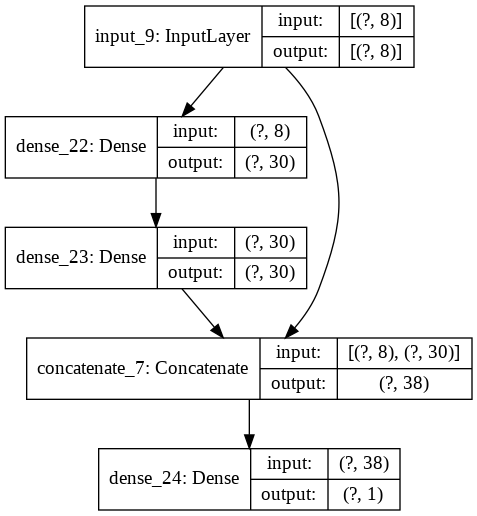

In [0]:
# What does the structure of this model look like?
keras.utils.plot_model(model, "wide_and_deep_california_housing.png", show_shapes=True)

In [0]:
# Can still examine the summary of this model
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 30)           270         input_9[0][0]                    
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 30)           930         dense_22[0][0]                   
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 38)           0           input_9[0][0]                    
                                                                 dense_23[0][0]             

## Compiling

In [0]:
# Same as with Sequential API
model.compile(loss='mean_squared_error', 
              optimizer='adam')

## Training

In [0]:
wdnn_history = model.fit(X_train_scaled, y_train, 
                         epochs=20, 
                         validation_data=(X_val_scaled, y_val))

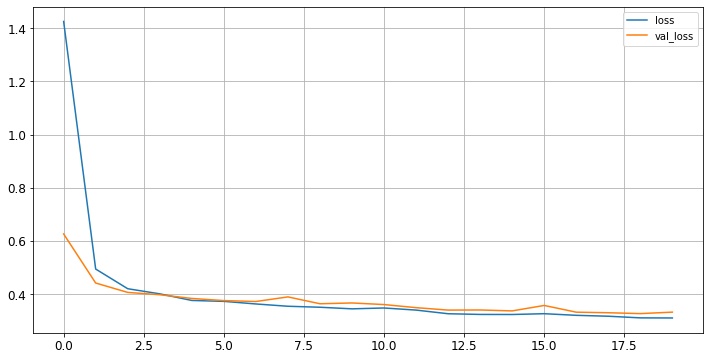

In [0]:
pd.DataFrame(wdnn_history.history).plot(figsize=(12, 6))
plt.grid(True)

This model seems to have done much better than the standalone DNN for the same number of epochs. However, I had to change the optimiser from an `SGD` with `lr = 1e-3` to `adam` for the loss to converge.

## Evaluating

In [0]:
print("MSE on test data", model.evaluate(X_test_scaled, y_test))

162/162 [==============================] - 0s 981us/step - loss: 0.3298
MSE on test data 0.3297705352306366


Much lower loss on the test data than the standalone DNN. 

# Second WDNN - Separating Inputs

What if we wanted to send a subset of the features through the wide path, and a different (possibly overlapping) subset through the deep path?

Can do this with the functional API

## Build Model

In [0]:
# Once again, defining a sequence of tensor transformations

# DIFFERENT INPUTS
input_A = keras.layers.Input(shape=[5], name='wide_input')  
input_B = keras.layers.Input(shape=[6], name='deep_input')    

# HIDDEN LAYERS IN DEEP COMPONENT
hidden_1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden_2 = keras.layers.Dense(30, activation='relu')(hidden_1)

# CONCATENATE THE WIDE INPUT WITH DEEP OUTPUT 
concat = keras.layers.Concatenate()([input_A, hidden_2])

# FEED TO SINGLE UNIT FOR PREDICTION
output = keras.layers.Dense(1, name='output')(concat)

In [0]:
# Building a multi-input model
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

## Examining Model

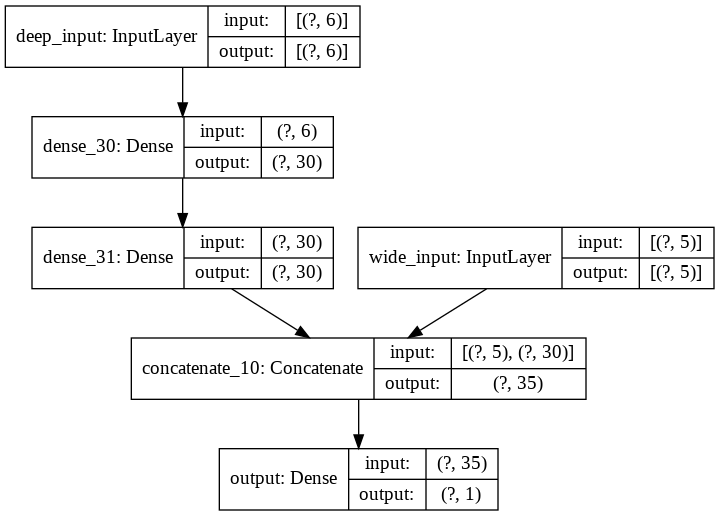

In [0]:
keras.utils.plot_model(model, "wide_and_deep_california_housing_2.png", show_shapes=True)

## Compiling

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [0]:
# Must also define which features to use for each component 

# Training inputs
X_train_A, X_train_B = X_train_scaled[:, :5], X_train_scaled[:, 2:]

# Validation inputs
X_valid_A, X_valid_B = X_val_scaled[:, :5], X_val_scaled[:, 2:]

# Test inputs
X_test_A, X_test_B = X_test_scaled[:, 5], X_test_scaled[:, 3:]

## Training

In [0]:
history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_val))

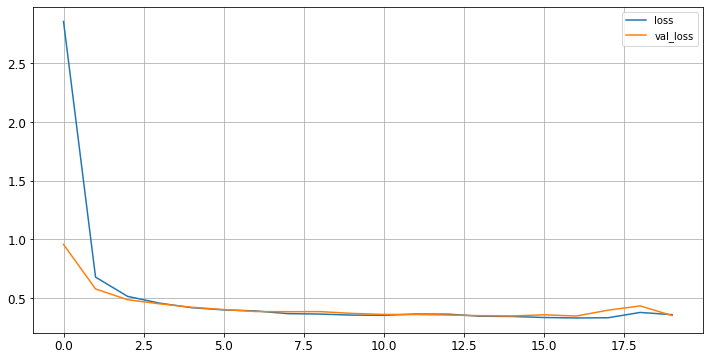

In [0]:
pd.DataFrame(history.history).plot(figsize=(12, 6))
plt.grid(True)

Doesn't seem to have done as well as the WDNN that used all features for both wide and deep components. 

This makes sense: in this model, both the wide and deep component see only a fraction of the total available input features. This is why they have lower predictive power than their WDNN 1 counterparts and don't do as well on this task.

# Third WDNN - Multiple Outputs

NNs with multiple outputs have the following use cases:
1. **Task requires multiple outputs** (e.g. regression output for bounding box dimensions and coordinates, classification output for object in the bounding box).

2. Multiple **independent tasks that will benefit from learning features** that are also used in other tasks.

3. As a **regularization technique**: adding an auxiliary output in a neural network can sometimes ensure that the underlying part of the network learns something useful on its own without relying on the rest of the network. 

## Building Model

Same as WDNN 2, but with an auxiliary output. The model's topology will be the same as that of the WDNN 1 and 2. The only difference is the addition of an auxiliary output layer to the last hidden layer of the deep component.

In [0]:
# INPUT TENSORS - Different subsets of input data for wide and deep components
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')

# HIDDEN LAYERS OF DEEP COMPONENT
hidden_1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden_2 = keras.layers.Dense(30, activation='relu')(hidden_1)

# CONCATENATION 
concat = keras.layers.Concatenate()([input_A, hidden_2])

# OUTPUTS
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden_2)

In [0]:
# Combine the transformations into an acyclic graph
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

## Examining WDNN

In [31]:
# What are the model's layers, IOs, parameters?
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           930         dense_4[0][0]                    
____________________________________________________________________________________________

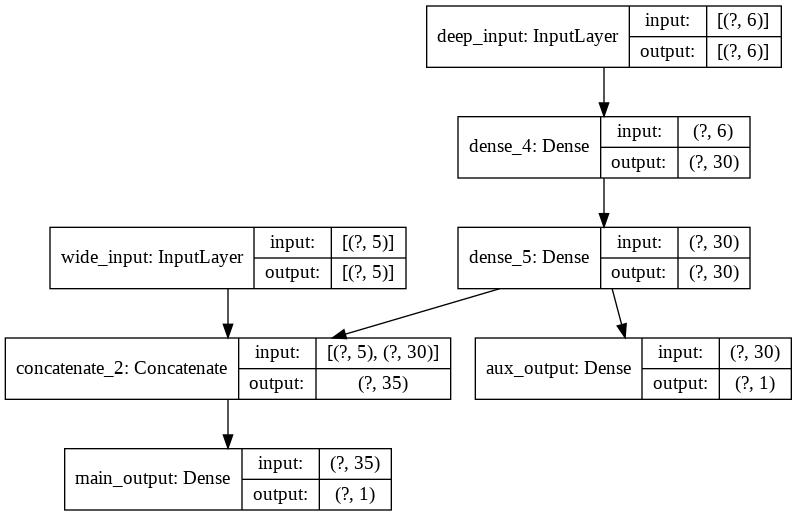

In [32]:
# What does the model's computation graph look like?
keras.utils.plot_model(model, 'wdnn_3.png', show_shapes=True)

## Compiling Model

- Need to specify a separate loss function for each output unless we want `keras` to use the same loss function for both.
- Our `output` is more important than our `aux_output` - the latter is just for regularization. So the loss for `output` should have a higher **weightage** than that for `aux_output`. 
- We want the auxiliary output and the main output to predict the same thing, so don't need to modify or index the training labels.

In [0]:
model.compile(optimizer='adam', loss=['mse', 'mse'], 
              loss_weights=[0.9, 0.1])

## Training Model

In [0]:
# Indexing to create different inputs for our model
X_train_A, X_train_B = X_train_scaled[:, :5], X_train_scaled[:, 2:]
X_valid_A, X_valid_B = X_val_scaled[:, :5], X_val_scaled[:, 2:]
X_test_A, X_test_B = X_test_scaled[:, :5], X_test_scaled[:, 2:]

In [35]:
wdnn_3_history = model.fit([X_train_A, X_train_B], [y_train, y_train], 
                           validation_data=([X_valid_A, X_valid_B], [y_val, y_val]), 
                           epochs=20)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.5296 - main_output_loss: 1.4733 - aux_output_loss: 2.0360 - val_loss: 0.6192 - val_main_output_loss: 0.5821 - val_aux_output_loss: 0.9534
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5721 - main_output_loss: 0.5495 - aux_output_loss: 0.7748 - val_loss: 0.4776 - val_main_output_loss: 0.4575 - val_aux_output_loss: 0.6592
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4647 - main_output_loss: 0.4452 - aux_output_loss: 0.6401 - val_loss: 0.4523 - val_main_output_loss: 0.4343 - val_aux_output_loss: 0.6145
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4299 - main_output_loss: 0.4108 - aux_output_loss: 0.6017 - val_loss: 0.4325 - val_main_output_loss: 0.4129 - val_aux_output_loss: 0.6088
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4093 - main_output_loss: 0.3913 - aux_output_loss: 0.5712 - val_loss

In [43]:
wdnn_3_history.history.keys()

dict_keys(['loss', 'main_output_loss', 'aux_output_loss', 'val_loss', 'val_main_output_loss', 'val_aux_output_loss'])

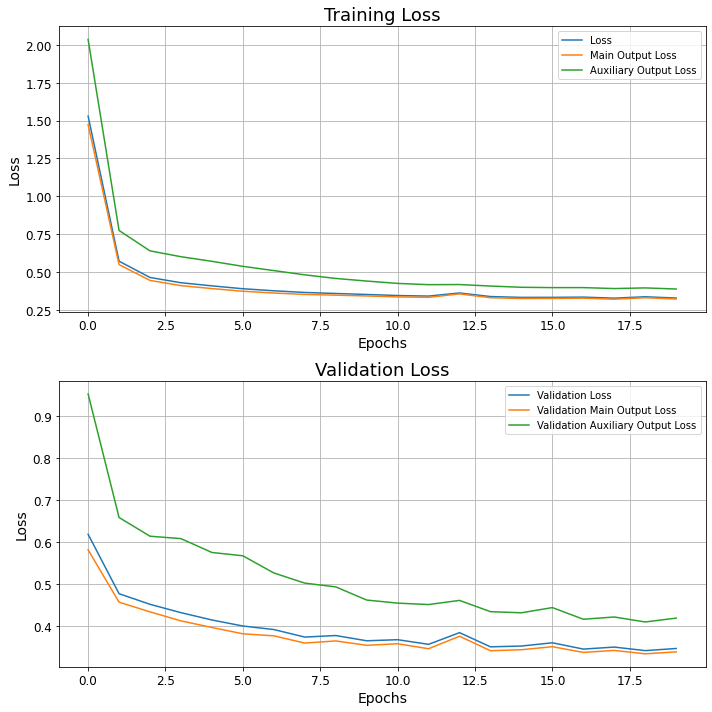

In [60]:
# Manually plotting the history for this one 
figure, axes = plt.subplots(2, 1, figsize=(10, 10))
history = wdnn_3_history.history 

# AXES 1 - TRAINING LOSSES 
axes[0].plot(history['loss'], label='Loss')
axes[0].plot(history['main_output_loss'], label='Main Output Loss')
axes[0].plot(history['aux_output_loss'], label='Auxiliary Output Loss')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epochs', fontsize=14)
axes[0].set_ylabel('Loss', fontsize=14)
axes[0].set_title('Training Loss', fontsize=18)

# AXES 2 - VALIDATION LOSS
axes[1].plot(history['val_loss'], label='Validation Loss')
axes[1].plot(history['val_main_output_loss'], label='Validation Main Output Loss')
axes[1].plot(history['val_aux_output_loss'], label='Validation Auxiliary Output Loss')
axes[1].legend()
axes[1].set_xlabel('Epochs', fontsize=14)
axes[1].set_ylabel('Loss', fontsize=14)
axes[1].set_title('Validation Loss', fontsize=18)
axes[1].grid(True)

plt.tight_layout()

Auxiliary loss is consistently higher than overall loss and main output loss. 

The higher weightage of main output loss means the overall training and validation loss is always lower than the auxiliary loss. 

Auxiliary output seems to have worked because the validaton categorcal  has dropped to well below 0.4, which is an improvement over the the previous model.

## Evaluating Model

In [61]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test]
)

162/162 [==============================] - 0s 1ms/step - loss: 0.3556 - main_output_loss: 0.3501 - aux_output_loss: 0.4054


Test set performance is closer to that of the original WDNN, even though each component has had access to fewer features. 

This goes to show that the model has been successful in mitigating overfitting to an extent.